In [1]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import graphviz

print("tensorflow version %s" % tf.__version__)
print("numpy      version %s" % np.__version__)
print("matplotlib version %s" % mpl.__version__)

tensorflow version 0.8.0
numpy      version 1.11.0
matplotlib version 1.5.1


# Tensorflow Detials
Within tensorflow, a `tf.Graph` is a directed acyclic graph of operations (`tf.Operations`) - also known as a call graph. There is a default graph (`tf.get_default_graph()`) and any new operations are added to this graph. `tf.Operations` operate on a `tf.Tensor` and return a `tf.Tensor` ($f:X->Y$, where $X$ and $Y$ are tensors).

Evaluation of the graph requires a session (`tf.Session()`). One can construct a global session (or can use context managers so that the sessions are independent - this is useful if wanting to compute something on a separate device). In addition there is a special session `tf.InteractiveSession()` - designed for interactive python environments, and it won't require referencing the specific session.

In [2]:
n_values = 32

#Using a context manager
with tf.Session() as session:
    x = tf.linspace(-3., 3., n_values)
    
    y = x.eval(session=session)
    z = session.run(x)
    print("x (and x[0]) type information:")
    print("------------------------------")
    print("type(x), x: ",type(x), x)
    print("type(x[0]), x[0]: ",type(x[0]), x[0])
    #type is purely a tensorflow object
    # ** It DOESN'T HAVE a Value **
    
    print()
    print("evaluated type information (explicit call to session.run or tf.eval):")
    print("---------------------------")
    print(type(y), y)
    #type is now a numpy object
    print(type(z), z)
    #type is now a numpy object
    
    print(type(session.run(x[0])),session.run(x[0]))
    #evaluates down to numpy.float32

x (and x[0]) type information:
------------------------------
type(x), x:  <class 'tensorflow.python.framework.ops.Tensor'> Tensor("LinSpace:0", shape=(32,), dtype=float32)
type(x[0]), x[0]:  <class 'tensorflow.python.framework.ops.Tensor'> Tensor("Squeeze_1:0", shape=(), dtype=float32)

evaluated type information (explicit call to session.run or tf.eval):
---------------------------
<class 'numpy.ndarray'> [-3.         -2.80645156 -2.61290312 -2.41935492 -2.22580647 -2.03225803
 -1.83870971 -1.64516139 -1.45161295 -1.25806451 -1.06451619 -0.87096786
 -0.67741942 -0.48387098 -0.29032278 -0.09677434  0.0967741   0.29032254
  0.48387098  0.67741919  0.87096763  1.06451607  1.25806427  1.45161295
  1.64516115  1.83870935  2.03225803  2.22580624  2.41935444  2.61290312
  2.80645132  3.        ]
<class 'numpy.ndarray'> [-3.         -2.80645156 -2.61290312 -2.41935492 -2.22580647 -2.03225803
 -1.83870971 -1.64516139 -1.45161295 -1.25806451 -1.06451619 -0.87096786
 -0.67741942 -0.48387098 -0.

In [3]:
#Can't use an interactive session within a context;
try:
    with tf.InteractiveSession() as session:
        print("Inside context")
except AttributeError as e:
    print("InteractiveSession doesn't have an %s" % e)

InteractiveSession doesn't have an __exit__


In [4]:
#Let's try running with the session (defined within the context manager)
try:
    session.run(x)
except RuntimeError as re:
    print("RuntimeError: %s" % re)
# (session is closed)

RuntimeError: Attempted to use a closed Session.


# tensorflow constants, variables (and lazy evaluation)
As mentioned earlier tensorflow stores computation as a call graph - or `dataflow graph` - and will not perform any calculations until the input data state is correct; - this is also known as **lazy evaluation**. There are a few advantages to this:
* tensorflow can be run on multiple computation devices (`/device:CPU:0` or `/cpu0`, `/device:GPU:i` or `/gpu:i` (`i`-th GPU device).
* lazy evaluation allows for arbitrary depth expression (recursive form);
* results that are never used, will never be evaluated

This contrasts the default `python` (and `numpy`) behaviour;

In [5]:
# python behaviour:
print("python behaviour:")
print("-----------------")
x = 1
y = x + 1
print(y)

#numpy behaviour
print()
print("numpy behaviour:")
print("----------------")
x = np.linspace(-3., 3., n_values)
y = x + 1
print(type(y),y)

print()
print("tensorflow behaviour:")
print("---------------------")
with tf.Session() as session:
    x = tf.linspace(-3., 3., n_values, name='x')
    y = tf.Variable(x + 5, name='y')
    print(type(y), y)


python behaviour:
-----------------
2

numpy behaviour:
----------------
<class 'numpy.ndarray'> [-2.         -1.80645161 -1.61290323 -1.41935484 -1.22580645 -1.03225806
 -0.83870968 -0.64516129 -0.4516129  -0.25806452 -0.06451613  0.12903226
  0.32258065  0.51612903  0.70967742  0.90322581  1.09677419  1.29032258
  1.48387097  1.67741935  1.87096774  2.06451613  2.25806452  2.4516129
  2.64516129  2.83870968  3.03225806  3.22580645  3.41935484  3.61290323
  3.80645161  4.        ]

tensorflow behaviour:
---------------------
<class 'tensorflow.python.ops.variables.Variable'> <tensorflow.python.ops.variables.Variable object at 0x7f2a40495e10>


# Explicit Initialization and Evaluation

In [6]:
with tf.Session() as session:
    x = tf.linspace(-3., 3., n_values, name='x')
    y = tf.Variable(x + 5, name='y')
    init_op = tf.initialize_all_variables()
    session.run(init_op)
    #initialize the 'variables'
    print(session.run(y))

[ 2.          2.19354844  2.38709688  2.58064508  2.77419353  2.96774197
  3.16129017  3.35483861  3.54838705  3.74193549  3.93548393  4.12903214
  4.32258034  4.51612902  4.70967722  4.9032259   5.0967741   5.2903223
  5.48387098  5.67741919  5.87096786  6.06451607  6.25806427  6.45161295
  6.64516115  6.83870935  7.03225803  7.22580624  7.41935444  7.61290312
  7.80645132  8.        ]


In [7]:
with tf.Session() as session:
    x = tf.linspace(-3., 3., n_values, name='x')
    y = tf.Variable(x + 5, name='y')
    init_op = tf.initialize_all_variables()
    print("is y initialized: ", session.run(tf.is_variable_initialized(y)))
    #variable is not initialized to explicitly initialized
    # (init_op has to be run)

is y initialized:  False


In [8]:
with tf.Session() as session:
    x = tf.linspace(-3., 3., n_values, name='x')
    y = tf.Variable(x + 5, name='y')
    print("is y initialized: ", session.run(tf.is_variable_initialized(y)))
    session.run(y.initializer)
    print("is y initialized: ", session.run(tf.is_variable_initialized(y)))
    #explicitly initialze 'y'
    print(session.run(y))

is y initialized:  False
is y initialized:  True
[ 2.          2.19354844  2.38709688  2.58064508  2.77419353  2.96774197
  3.16129017  3.35483861  3.54838705  3.74193549  3.93548393  4.12903214
  4.32258034  4.51612902  4.70967722  4.9032259   5.0967741   5.2903223
  5.48387098  5.67741919  5.87096786  6.06451607  6.25806427  6.45161295
  6.64516115  6.83870935  7.03225803  7.22580624  7.41935444  7.61290312
  7.80645132  8.        ]


In [9]:
with tf.Session() as session:
    x = tf.linspace(-3., 3., n_values, name='x')
    y = tf.Variable(x + 5, name='y')
    z = tf.Variable(y - 3, name='z')
    print("is y initialized: ", session.run(tf.is_variable_initialized(y)))
    session.run(y.initializer)
    print("is y initialized: ", session.run(tf.is_variable_initialized(y)))
    #explicitly initialze 'y'
    print("is z initialized: ", session.run(tf.is_variable_initialized(z)))
    try:
        session.run(z)
    except tf.errors.FailedPreconditionError as FPE:
        print("z is uninitialized (as expected)\n %s" % FPE)
    #z is no initialized (only y is initialized)
    init_yz = tf.initialize_variables([y,z])
    #initialize variables in the list (and only those variables)
    session.run(init_yz)
    print("is z initialized: ", session.run(tf.is_variable_initialized(z)))
    

is y initialized:  False
is y initialized:  True
is z initialized:  False
z is uninitialized (as expected)
 Attempting to use uninitialized value z
	 [[Node: _send_z_0 = _Send[T=DT_FLOAT, client_terminated=true, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=-7050753528221258384, tensor_name="z:0", _device="/job:localhost/replica:0/task:0/cpu:0"](z)]]
is z initialized:  True


# Methods of Initializing Variables:
 * `tf.Variable.initializer`
 * `tf.initialize_variable([<list>])`
 * `tf.initialize_all_variables()`



In [10]:
#Getting a list of all variables:
variables = tf.all_variables()
for var in variables:
    print(var.name)

#Notice the names:


y:0
y_1:0
y_2:0
y_3:0
y_4:0
z:0


# Variables:
Each time a variable is declared: `tf.Variable(..., name='y')` it is given a unique identifier (unless the variables are declared within a `variable_scope` with `reuse` set to true).

In [11]:
#without shape information get_variable will fail;
try:
    tf.get_variable("y")
except ValueError as ve:
    print("Require shape information!\n %s" % ve)



Require shape information!
 Shape of a new variable (y) must be fully defined, but instead was <unknown>.


# Variable Scope
Imagine you create a simple model for image filters (in this case only 2 convolutions). If you use `tf.Variable` you could define the following functions:
```
def image_filters(in_image):
    conv1_weights = tf.Variable(tf.random_normal([5, 5, 32, 32]),
        name="conv1_weights")
    conv1_biases = tf.Variable(tf.zeros([32]), name="conv1_biases")
    conv1 = tf.nn.conv2d(in_image, conv1_weights,
        strides=[1, 1, 1, 1], padding='SAME')
    relu1 = tf.nn.relu(conv1 + conv1_biases)

    conv2_weights = tf.Variable(tf.random_normal([5, 5, 32, 32]),
        name="conv2_weights")
    conv2_biases = tf.Variable(tf.zeros([32]), name="conv2_biases")
    conv2 = tf.nn.conv2d(relu1, conv2_weights,
        strides=[1, 1, 1, 1], padding='SAME')
    return tf.nn.relu(conv2 + conv2_biases)
```

This creates 4 variables per function call; `conv1_biases`, `conv2_biases`, `conv1_weights`, `conv2_weights`;

```
result1 = image_filter(image_1)
result2 = image_filter(image_2)
```
This would create two sets of variables;

In [12]:
tf.reset_default_graph()
variables = tf.all_variables()
for var in variables:
    print(var.name)
#cleared the state;

def image_filters(in_image):
    conv1_weights = tf.Variable(tf.random_normal([3, 3, 1, 32]),
        name="conv1_weights")
    conv1_biases = tf.Variable(tf.zeros([32]), name="conv1_biases")
    conv1 = tf.nn.conv2d(in_image, conv1_weights,
        strides=[1, 1, 1, 1], padding='SAME')
    relu1 = tf.nn.relu(conv1 + conv1_biases)

    conv2_weights = tf.Variable(tf.random_normal([3, 3, 32, 32]),
        name="conv2_weights")
    conv2_biases = tf.Variable(tf.zeros([32]), name="conv2_biases")
    conv2 = tf.nn.conv2d(relu1, conv2_weights,
        strides=[1, 1, 1, 1], padding='SAME')
    return tf.nn.relu(conv2 + conv2_biases)

x = tf.placeholder(shape=[None, 784], dtype=tf.float32)
x_image = tf.reshape(x, [-1,28,28,1])

image_filters(x_image)
image_filters(x_image)

variables = tf.all_variables()
for var in variables:
    print(var.name)

conv1_weights:0
conv1_biases:0
conv2_weights:0
conv2_biases:0
conv1_weights_1:0
conv1_biases_1:0
conv2_weights_1:0
conv2_biases_1:0


# Common Solution (using a Dictionary)

```
variables_dict = {
    "conv1_weights": tf.Variable(tf.random_normal([5, 5, 32, 32]),
        name="conv1_weights")
    "conv1_biases": tf.Variable(tf.zeros([32]), name="conv1_biases")
    #... etc. ...
}

def my_image_filter(input_images, variables_dict):
    conv1 = tf.nn.conv2d(input_images, variables_dict["conv1_weights"],
        strides=[1, 1, 1, 1], padding='SAME')
    relu1 = tf.nn.relu(conv1 + variables_dict["conv1_biases"])

    conv2 = tf.nn.conv2d(relu1, variables_dict["conv2_weights"],
        strides=[1, 1, 1, 1], padding='SAME')
    return tf.nn.relu(conv2 + variables_dict["conv2_biases"])

# The 2 calls to my_image_filter() now use the same variables
result1 = my_image_filter(image1, variables_dict)
result2 = my_image_filter(image2, variables_dict)
```
## PROBLEMS (Breaks encapsulation):
* The code that builds the graph must document the names, types, and shapes of variables to create (development issue).
* When the code changes, the callers may have to create more, or less, or different variables (development issue).

**One way to address the problem is to use classes to create a model, where the classes take care of managing the variables they need. For a lighter solution, not involving classes, TensorFlow provides a Variable Scope mechanism that allows to easily share named variables while constructing a graph.**

# Variable Scope:

Variable scope mechanism consists of 2 primary functions:
* `tf.get_variable(<name>, <shape>, <initializer>)`: CREATES or RETURNS a variable with a given name.
* `tf.variable_scope(<scope_name>)`: MANAGES namespaces for names passed to `tf.get_variable`

The function `tf.get_variable()` is used to get or create a variable instead of a direct call to `tf.Variable`. It uses an initializer instead of passing the value directly, as in `tf.Variable`. An initializer is a function that takes the shape and provides a tensor with that shape. Here are some initializers available in TensorFlow:

* `tf.constant_initializer(value)` initializes everything to the provided value,
* `tf.random_uniform_initializer(a, b)` initializes uniformly from [a, b],
* `tf.random_normal_initializer(mean, stddev)` initializes from the normal distribution with the given mean and standard deviation.

## Usage:

In [13]:
tf.reset_default_graph()
variables = tf.all_variables()
for var in variables:
    print(var.name)

def conv_relu(input, kernel_shape, bias_shape):
    # Create variable named "weights".
    weights = tf.get_variable("weights", kernel_shape,
        initializer=tf.random_normal_initializer())
    # Create variable named "biases".
    biases = tf.get_variable("biases", bias_shape,
        initializer=tf.constant_initializer(0.0))
    conv = tf.nn.conv2d(input, weights,
        strides=[1, 1, 1, 1], padding='SAME')
    return tf.nn.relu(conv + biases)

def my_image_filter(in_input):
    with tf.variable_scope("conv1"):
        # Variables created here will be named "conv1/weights",
        #                                      "conv1/biases".
        relu1 = conv_relu(in_input, [5, 5, 1, 32], [32])
    with tf.variable_scope("conv2"):
        # Variables created here will be named "conv2/weights",
        #                                      "conv2/biases".
        return conv_relu(relu1, [5, 5, 32, 32], [32])

x = tf.placeholder(shape=[None, 784], dtype=tf.float32)
x_image = tf.reshape(x, [-1,28,28,1])

my_image_filter(x_image)

variables = tf.all_variables()
for var in variables:
    print(var.name)
# Now if my_image_filter is called again (we have a problem)
# Raises ValueError( ... name already exists in scope ...)

tf.reset_default_graph()

x = tf.placeholder(shape=[None, 784], dtype=tf.float32)
x_image = tf.reshape(x, [-1,28,28,1])

with tf.variable_scope("image_filters") as scope:
    result1 = my_image_filter(x_image)
    scope.reuse_variables()
    result2 = my_image_filter(x_image)
    
variables = tf.all_variables()
for var in variables:
    print(var.name) 

conv1/weights:0
conv1/biases:0
conv2/weights:0
conv2/biases:0
image_filters/conv1/weights:0
image_filters/conv1/biases:0
image_filters/conv2/weights:0
image_filters/conv2/biases:0


# Operations
Basic Operations examples; Including the use of placeholders (and feed_dict for evaluation);

In [14]:
tf.reset_default_graph()

#Going to create an interactive session
sess = tf.InteractiveSession()

In [15]:
a = tf.constant(2)
b = tf.constant(3)

#Can evaluate constants through a sess.run() or eval()
print(sess.run(a+b), sess.run(a*b))
print((a+b).eval(),  (a*b).eval())

hello = tf.constant("hello")
print(hello.eval())
#notice type is bytes;

5 6
5 6
b'hello'


In [16]:
a_ph = tf.placeholder(tf.int32, name='a_ph')
b_ph = tf.placeholder(tf.int32, name='b_ph')

c = a_ph + b_ph
d = a_ph * b_ph

print(sess.run(c, feed_dict={a_ph: 2, b_ph:3}))
print(sess.run(d, feed_dict={a_ph: 2, b_ph:3}))

5
6


In [17]:
matrix1 = tf.constant([[3., 3.]])#1x2
matrix2 = tf.constant([[2.],[2.]])#2x1
product12 = tf.matmul(matrix1, matrix2)
product21 = tf.matmul(matrix2, matrix1)
#notice:
broadcast12 = matrix1 * matrix2
broadcast21 = matrix2 * matrix1
print("Matrix Product")
print(sess.run(product12))
print(sess.run(product21))

print("Broadcast")
print(sess.run(broadcast12))
print(sess.run(broadcast21))

Matrix Product
[[ 12.]]
[[ 6.  6.]
 [ 6.  6.]]
Broadcast
[[ 6.  6.]
 [ 6.  6.]]
[[ 6.  6.]
 [ 6.  6.]]


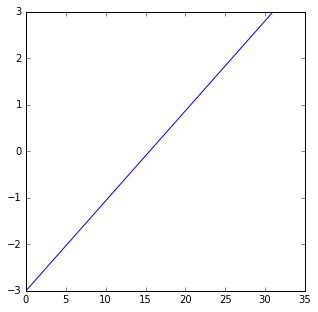

In [18]:
x = tf.linspace(-3., 3., n_values)
plt.figure(figsize=(5,5))
X = x.eval()
plt.plot(X)

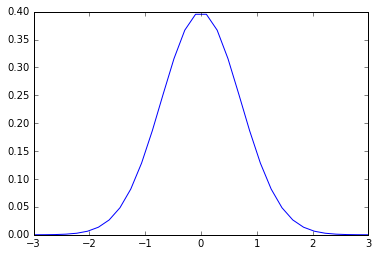

In [19]:
sigma = 1.0
mean = 0.0

z = tf.exp( - ((x - mean) / sigma) ** 2) / np.sqrt((2.0 * sigma**2 * np.math.pi))
Z = z.eval()
plt.plot(X, Z)

In [20]:
#subtle difference between numpy and tensorflow:
print(Z.shape)
print(z.get_shape())

(32,)
(32,)


In [21]:
z_2d = tf.matmul(tf.reshape(z, [n_values, 1]), tf.reshape(z, [1, n_values]))
#(100x1) * (1x100) = (100x100)
z_2d_alt = tf.reshape(z, [n_values, 1]) *  tf.reshape(z, [1, n_values])

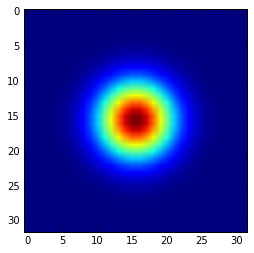

In [22]:
plt.imshow(z_2d.eval())

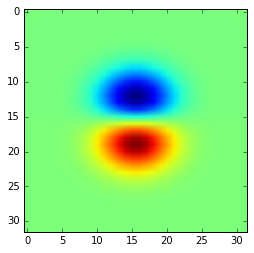

In [23]:
x = tf.reshape(tf.sin(tf.linspace(-3.0, 3.0, n_values)), [n_values, 1])
y = tf.reshape(tf.ones_like(x), [1, n_values])
z = tf.mul(tf.matmul(x, y), z_2d)
plt.imshow(z.eval())

In [24]:
#Getting all operations in the graph :/
ops = tf.get_default_graph().get_operations()
print([op.name for op in ops])

['Const', 'Const_1', 'add', 'mul', 'add_1', 'mul_1', 'Const_2', 'a_ph', 'b_ph', 'add_2', 'mul_2', 'Const_3', 'Const_4', 'MatMul', 'MatMul_1', 'mul_3', 'mul_4', 'LinSpace/start', 'LinSpace/stop', 'LinSpace/num', 'LinSpace', 'sub/y', 'sub', 'truediv/y', 'truediv', 'pow/y', 'pow', 'Neg', 'Exp', 'truediv_1/y', 'truediv_1', 'Reshape/shape', 'Reshape', 'Reshape_1/shape', 'Reshape_1', 'MatMul_2', 'Reshape_2/shape', 'Reshape_2', 'Reshape_3/shape', 'Reshape_3', 'mul_5', 'LinSpace_1/start', 'LinSpace_1/stop', 'LinSpace_1/num', 'LinSpace_1', 'Sin', 'Reshape_4/shape', 'Reshape_4', 'ones_like/Shape', 'ones_like/Const', 'ones_like', 'Reshape_5/shape', 'Reshape_5', 'MatMul_3', 'Mul']


In [25]:
def gabor(n_values=32, sigma=1.0, mean=0.0):
    x = tf.linspace(-3.0, 3.0, n_values)
    z = (tf.exp(tf.neg(tf.pow(x - mean, 2.0) /
                       (2.0 * tf.pow(sigma, 2.0)))) *
         (1.0 / (sigma * tf.sqrt(2.0 * 3.1415))))
    gauss_kernel = tf.matmul(
        tf.reshape(z, [n_values, 1]), tf.reshape(z, [1, n_values]))
    x = tf.reshape(tf.sin(tf.linspace(-3.0, 3.0, n_values)), [n_values, 1])
    y = tf.reshape(tf.ones_like(x), [1, n_values])
    gabor_kernel = tf.mul(tf.matmul(x, y), gauss_kernel)
    return gabor_kernel

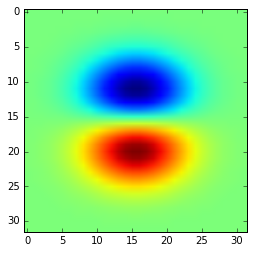

In [26]:
plt.imshow(gabor().eval())

In [27]:
def convolve(img, W):
    # The W matrix is only 2D
    # But conv2d will need a tensor which is 4d:
    # height x width x n_input x n_output
    if len(W.get_shape()) == 2:
        dims = W.get_shape().as_list() + [1, 1]
        W = tf.reshape(W, dims)

    if len(img.get_shape()) == 2:
        # num x height x width x channels
        dims = [1] + img.get_shape().as_list() + [1]
        img = tf.reshape(img, dims)
    elif len(img.get_shape()) == 3:
        dims = [1] + img.get_shape().as_list()
        img = tf.reshape(img, dims)
        # if the image is 3 channels, then our convolution
        # kernel needs to be repeated for each input channel
        W = tf.concat(2, [W, W, W])

    # Stride is how many values to skip for the dimensions of
    # num, height, width, channels
    convolved = tf.nn.conv2d(img, W,
                             strides=[1, 1, 1, 1], padding='SAME')
    return convolved

(512, 512, 3)


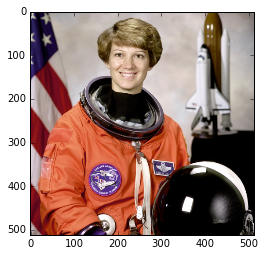

In [28]:
from skimage import data
img = data.astronaut()
plt.imshow(img)
print(img.shape)

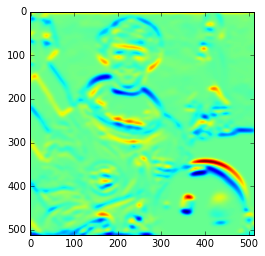

In [29]:
x = tf.placeholder(tf.float32, shape=img.shape)
out = convolve(x, gabor())
result = tf.squeeze(out).eval(feed_dict={x: img})
plt.imshow(result)